<a href="https://colab.research.google.com/github/elmedianikhadija/PFE-WITH-SIR/blob/main/1%C3%A9re_essaye.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
# Stable version in PyPI
!pip install --upgrade covsirphy

  Using cached funcparserlib-1.0.0a0-py2.py3-none-any.whl (17 kB)
  Attempting uninstall: funcparserlib
    Found existing installation: funcparserlib 1.0.0a1
    Uninstalling funcparserlib-1.0.0a1:
      Successfully uninstalled funcparserlib-1.0.0a1


In [101]:
# Development version in GitHub
!pip install --upgrade "git+https://github.com/lisphilar/covid19-sir.git#egg=covsirphy"

  Cloning https://github.com/lisphilar/covid19-sir.git to /tmp/pip-install-k87jk3mh/covsirphy_6b0fdceeafcd46e8b1151807b2191063
  Running command git clone -q https://github.com/lisphilar/covid19-sir.git /tmp/pip-install-k87jk3mh/covsirphy_6b0fdceeafcd46e8b1151807b2191063
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached funcparserlib-1.0.0a1-py2.py3-none-any.whl (17 kB)
  Attempting uninstall: funcparserlib
    Found existing installation: funcparserlib 1.0.0a0
    Uninstalling funcparserlib-1.0.0a0:
      Successfully uninstalled funcparserlib-1.0.0a0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
covsirphy 2.24.0 requires funcparserlib==1.0.0a0, but you have funcparserlib 1.0.0a1 which is incompatible.


In [102]:
import covsirphy as cs
cs.__version__

'2.24.0'

In [103]:
!pip install openpyxl

In [104]:
! pip install dask

In [105]:
pip install dask[dataframe] --upgrade

In [106]:
from collections import defaultdict
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import functools
from IPython.display import display, Markdown
import math
import os
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
import numpy as np
import pandas as pd
import dask.dataframe as dd
pd.plotting.register_matplotlib_converters()
import seaborn as sns
import scipy as sci
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import sympy as sym

In [107]:
# Ramdam
np.random.seed(123)
os.environ["PYTHONHASHSEED"] = "123"
# Matplotlib
plt.style.use("seaborn-ticks")
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["font.size"] = 11.0
plt.rcParams["figure.figsize"] = (9, 6)
# Pandas
pd.set_option("display.max_colwidth", 1000)

In [108]:
# Create instance of covsirphy.DataLoader class
data_loader = cs.DataLoader(directory="kaggle/input")
# Retrieve the dataset of the number of COVID-19 cases
# Kaggle platform: covid19dh.csv will be saved in /output/kaggle/working/input
# Local env: covid19dh.csv will be saved in kaggle/input
jhu_data = data_loader.jhu()

In [117]:
data_loader.head

AttributeError: ignored

Le jeu de données nettoyé (de tous les pays) a été sauvegardé dans jhu_data et nous pouvons obtenir le jeu de données nettoyé en tant que pandas.DataFrame.

In [109]:
jhu_data.cleaned().tail()

,Date,ISO3,Country,Province,Confirmed,Infected,Fatal,Recovered,Population
1246837,2022-04-18,ZWE,Zimbabwe,-,247297,158839,5464,82994,14439018
1246838,2022-04-19,ZWE,Zimbabwe,-,247297,158839,5464,82994,14439018
1246839,2022-04-20,ZWE,Zimbabwe,-,247336,158876,5466,82994,14439018
1246840,2022-04-21,ZWE,Zimbabwe,-,247383,158922,5467,82994,14439018
1246841,2022-04-22,ZWE,Zimbabwe,-,247488,159026,5468,82994,14439018


In [110]:
data = jhu_data.subset("morocco", province=None).tail()


In [111]:
data.to_csv("DATAsir.csv", index=False)

In [118]:
df = jhu_data.cleaned()
jhu_first_date, jhu_last_date = df["Date"].min(), df["Date"].max()
jhu_elapsed = (jhu_last_date - jhu_first_date).days
print(f"{jhu_elapsed} days have passed from the date of the first record.")

843 days have passed from the date of the first record.


#Pyramide des âges

Nous allons utiliser la pyramide des âges pour estimer le nombre de jours de sortie en moyenne.


In [119]:
pyramid_data = data_loader.pyramid()

In [120]:
print(pyramid_data)

In [121]:
# @marcoferrante estimation
_period_of_life_list = [
    "nursery", "nursery school", "elementary school", "middle school",
    "high school", "university/work", "work", "work", "work", "work",
    "retired", "retired", "retired"
]
df = pd.DataFrame(
    {
        "Age_first": [0, 3, 6, 11, 14, 19, 26, 36, 46, 56, 66, 76, 86],
        "Age_last": [2, 5, 10, 13, 18, 25, 35, 45, 55, 65, 75, 85, 95],
        "Period_of_life": _period_of_life_list,
        "Days": [3, 5, 6, 6, 7, 7, 6, 5, 5, 5, 4, 3, 2]
    }
)
# Adjustment by author
df["Types"] = df["Period_of_life"].replace(
    {
        "nursery": "school",
        "nursery school": "school",
        "elementary school": "school",
        "middle school": "school",
        "high school": "school",
        "university/work": "school/work"
    }
)
df["School"] = df[["Types", "Days"]].apply(lambda x: x[1] if "school" in x[0] else 0, axis=1)
df["Office"] = df[["Types", "Days"]].apply(lambda x: x[1] if "work" in x[0] else 0, axis=1)
df["Others"] = df["Days"] - df[["School", "Office"]].sum(axis=1)
df.loc[df["Others"] < 0, "Others"] = 0
df.loc[df.index[1:5], "School"] -= 1
df.loc[df.index[1:5], "Others"] += 1
df.loc[df.index[5], ["School", "Office", "Others"]] = [3, 3, 1]
df[["School", "Office", "Others"]] = df[["Days", "School", "Office", "Others"]].apply(
    lambda x: x[1:] / sum(x[1:]) * x[0], axis=1
).astype(np.int64)
df.loc[df.index[6:10], "Others"] += 1
df = df.drop(["Days", "Types"], axis=1)
# Show dataset
_out_df = df.copy()
_out_df

,Age_first,Age_last,Period_of_life,School,Office,Others
0,0,2,nursery,3,0,0
1,3,5,nursery school,4,0,1
2,6,10,elementary school,5,0,1
3,11,13,middle school,5,0,1
4,14,18,high school,6,0,1
5,19,25,university/work,3,3,1
6,26,35,work,0,6,1
7,36,45,work,0,5,1
8,46,55,work,0,5,1
9,56,65,work,0,5,1


In [122]:
def go_out(country, pyramid_data=pyramid_data):
    """
    Return the estimated number of days people usually go out.
    Args:
        country (str): coutry name
        pyramid_data (covsirphy.PopulationPyramidData): pyramid dataset
    
    Returns:
        pandas.DataFrame
    """
    p_df = pyramid_data.subset(country)
    p_df["Cumsum"] = p_df["Population"].cumsum()
    df = pd.merge(_out_df, p_df, left_on="Age_last", right_on="Age", how="left")
    df["Population"] = df["Cumsum"].diff()
    df.loc[df.index[0], "Population"] = df.loc[df.index[0], "Cumsum"]
    df["Population"] = df["Population"].astype(np.int64)
    df["Portion"] = df["Population"] / df["Population"].sum()
    return df.drop(["Per_total", "Cumsum"], axis=1)

go_out("morocco")

,Age_first,Age_last,Period_of_life,School,Office,Others,Age,Population,Portion
0,0,2,nursery,3,0,0,2,1995021,0.055494
1,3,5,nursery school,4,0,1,5,2015529,0.056064
2,6,10,elementary school,5,0,1,10,3367580,0.093673
3,11,13,middle school,5,0,1,13,1876560,0.052199
4,14,18,high school,6,0,1,18,3001192,0.083482
5,19,25,university/work,3,3,1,25,4070044,0.113213
6,26,35,work,0,6,1,35,5818458,0.161847
7,36,45,work,0,5,1,45,4973897,0.138355
8,46,55,work,0,5,1,55,3961972,0.110207
9,56,65,work,0,5,1,65,3256162,0.090574


In [123]:
data_cols = ["Infected", "Fatal", "Recovered"]
rate_cols = ["Fatal per Confirmed", "Recovered per Confirmed", "Fatal per (Fatal or Recovered)"]

In [124]:
total_df = jhu_data.total()
total_df = total_df.loc[total_df.index <= jhu_last_date, :]
total_df.tail()

,Confirmed,Infected,Fatal,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2022-04-19,503569405,307936406,6225148,189407851,0.012362,0.376131,0.031821
2022-04-20,500878917,305401833,6215494,189261590,0.012409,0.377859,0.031797
2022-04-21,498955935,306013800,6013928,186928207,0.012053,0.374639,0.031170
2022-04-22,462329356,278100136,5602874,178626346,0.012119,0.386362,0.030413
2022-04-23,97185526,38172292,1217640,57795594,0.012529,0.594693,0.020633


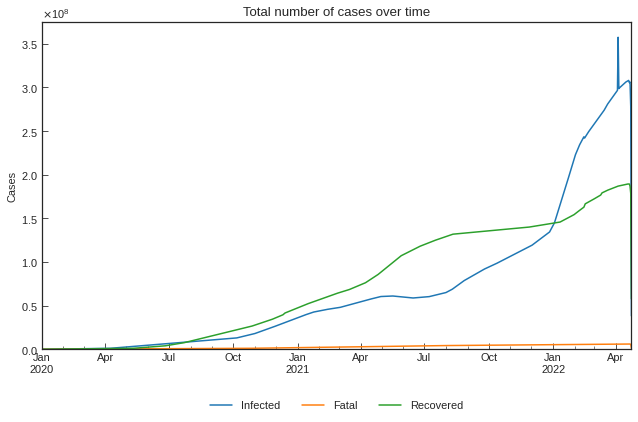

In [125]:
cs.line_plot(total_df[data_cols], "Total number of cases over time")

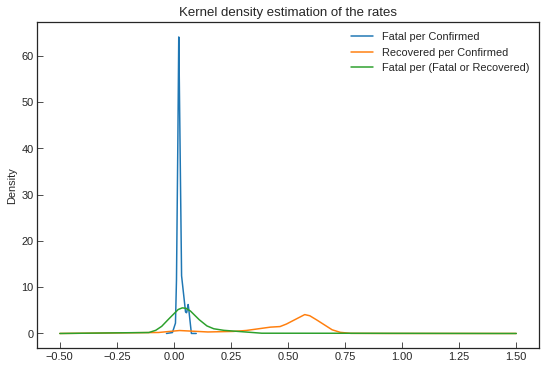

In [126]:
total_df[rate_cols].plot.kde()
plt.title("Kernel density estimation of the rates")
plt.show()

In [127]:
total_df[rate_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Fatal per Confirmed,842.0,0.026826,0.013113,0.0,0.020471,0.021713,0.030611,0.0652
Recovered per Confirmed,842.0,0.466117,0.183216,0.0,0.392389,0.552556,0.581523,1.0000
Fatal per (Fatal or Recovered),834.0,0.118812,0.220634,0.0,0.034052,0.036755,0.064025,1.0000


#SIR to SIR-F

Dans cette section, nous allons créer un modèle mathématique personnalisé dérivé du modèle SIR.

Qu'est-ce que le modèle SIR ?
Le modèle SIR est un modèle mathématique simple permettant de comprendre les épidémies de maladies infectieuses.
Le modèle épidémique SIR - Apprendre la programmation scientifique avec Python

S : Susceptible (= Population - Confirmed)

I : Infected (=Confirmed - Recovered - Fatal)

R : Recovered or Fatal (= Recovered + Fatal)

#Example of non-dimensional SIR model

In [128]:
# Set tau value and start date of records
# For explanation, the start date will be 01Jan2020
# This is not based on actual data
example_data = cs.ExampleData(tau=1440, start_date="01Jan2020")
# No records has been registered
example_data.cleaned()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered


In [129]:
# Model name
print(cs.SIR.NAME)
# Example parameter values
pprint(cs.SIR.EXAMPLE, compact=True)

SIR
{'param_dict': {'rho': 0.2, 'sigma': 0.075},
 'population': 1000000,
 'step_n': 180,
 'y0_dict': {'Fatal or Recovered': 0, 'Infected': 1000, 'Susceptible': 999000}}


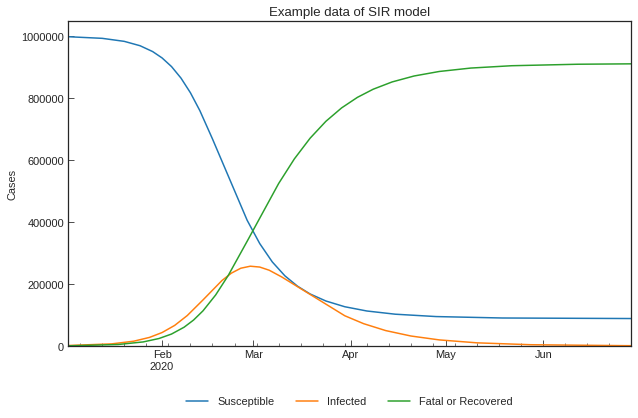

In [130]:
model = cs.SIR
area = {"country": "Full", "province": model.NAME}
# Add records with SIR model
example_data.add(model, **area)
# Records with model variables
df = example_data.specialized(model, **area)
cs.line_plot(
    df.set_index("Date"),
    title=f"Example data of {model.NAME} model",
    y_integer=True
)

Il existe un point d'inflexion de y (le nombre de cas actuels d'infection par rapport à la population totale). À ce point, la valeur de x (le nombre de cas sensibles par rapport à la population totale) est presque égale à 1/R0 .

In [131]:
eg_r0 = model(model.EXAMPLE["population"], **model.EXAMPLE["param_dict"]).calc_r0()
df = example_data.specialized(model, **area)
x_max = df.loc[df["Infected"].idxmax(), "Susceptible"] / cs.SIR.EXAMPLE["population"]
(x_max, 1/eg_r0)

(0.366211, 0.37453183520599254)

#Modèle SIR-D
Comme nous mesurons séparément le nombre de cas mortels et de cas guéris, nous pouvons utiliser deux variables ("guéris" et "décès") au lieu de "guéris + décès" dans le modèle mathématique.

In [132]:
# Model name
print(cs.SIRD.NAME)
# Example parameter values
pprint(cs.SIRD.EXAMPLE, compact=True)

SIR-D
{'param_dict': {'kappa': 0.005, 'rho': 0.2, 'sigma': 0.075},
 'population': 1000000,
 'step_n': 180,
 'y0_dict': {'Fatal': 0,
             'Infected': 1000,
             'Recovered': 0,
             'Susceptible': 999000}}


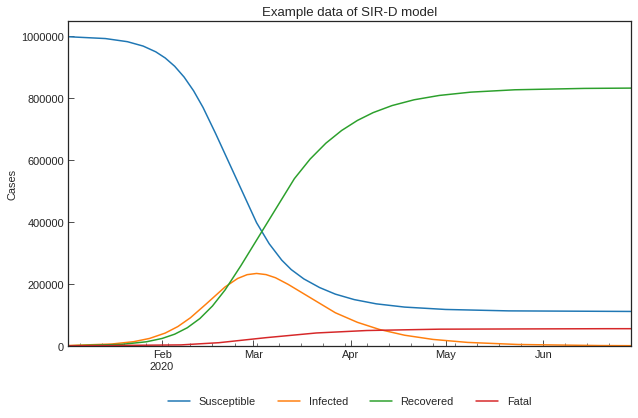

In [133]:
model = cs.SIRD
area = {"country": "Full", "province": model.NAME}
# Add records with SIR model
example_data.add(model, **area)
# Records with model variables
df = example_data.specialized(model, **area)
cs.line_plot(
    df.set_index("Date"),
    title=f"Example data of {model.NAME} model",
    y_integer=True
)

Il existe un point d'inflexion de y (le nombre de cas d'infection actuels par rapport à la population totale). A ce point, la valeur de x (le nombre de cas sensibles par rapport à la population totale) est presque égale à 1/R0 .

In [134]:
eg_r0 = model(model.EXAMPLE["population"], **model.EXAMPLE["param_dict"]).calc_r0()
df = example_data.specialized(model, **area)
x_max = df.loc[df["Infected"].idxmax(), "Susceptible"] / cs.SIR.EXAMPLE["population"]
(x_max, 1/eg_r0)

(0.397814, 0.4)

#Modèle SIR-F
Dans la phase initiale de l'épidémie de COVID-19, de nombreux cas ont été confirmés après leur décès. Pour prendre en compte ce problème, " S + I → Fatal + I " sera ajouté au modèle. Lorsque α1=0, le modèle SIR-F sera identique au modèle SIR-D.

#Example of non-dimensional SIR-F model

In [135]:
# Model name
print(cs.SIRF.NAME)
# Example parameter values
pprint(cs.SIRF.EXAMPLE, compact=True)

SIR-F
{'param_dict': {'kappa': 0.005, 'rho': 0.2, 'sigma': 0.075, 'theta': 0.002},
 'population': 1000000,
 'step_n': 180,
 'y0_dict': {'Fatal': 0,
             'Infected': 1000,
             'Recovered': 0,
             'Susceptible': 999000}}


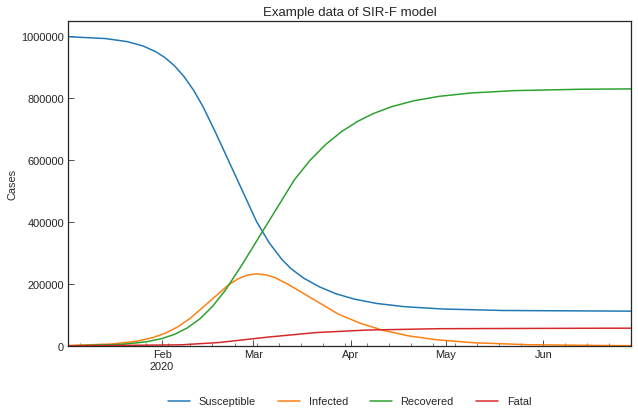

In [136]:
model = cs.SIRF
area = {"country": "Full", "province": model.NAME}
# Add records with SIR model
example_data.add(model, **area)
# Records with model variables
df = example_data.specialized(model, **area)
cs.line_plot(
    df.set_index("Date"),
    title=f"Example data of {model.NAME} model",
    y_integer=True
)

In [137]:
eg_r0 = model(model.EXAMPLE["population"], **model.EXAMPLE["param_dict"]).calc_r0()
df = example_data.specialized(model, **area)
x_max = df.loc[df["Infected"].idxmax(), "Susceptible"] / cs.SIR.EXAMPLE["population"]
(x_max, 1/eg_r0)

(0.401442, 0.4)

Optimisation des hyperparamètres
Dans les paragraphes précédents, nous avons calculé le nombre de cas en fonction des valeurs hypothétiques des paramètres. Cependant, nous ne connaissons pas les valeurs des paramètres des données réelles. Ici, nous allons estimer les valeurs ( θ,κ,ρ,σ ) des données de l'exemple en utilisant la méthode d'optimisation des hyperparamètres par le package Optuna. τ sera fixé à 1440 [min].

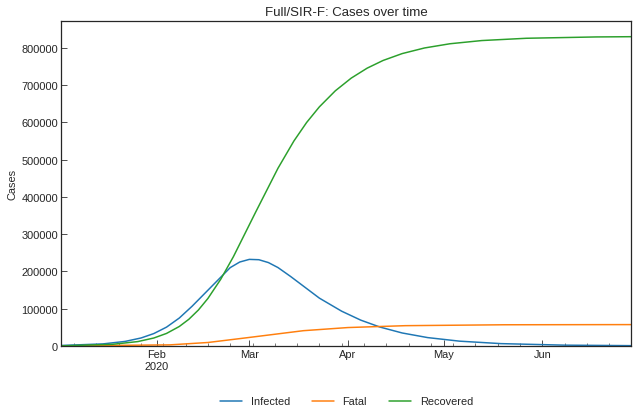

In [138]:
# Show records in JHU-style
sirf_snl = cs.Scenario(example_data, tau=1440, **area)
_ = sirf_snl.records()

In [139]:
# Set phases (phase: explained in "S-R trend analysis section")
# Records at 01Jan2020 will be removed because Recovered = 0
sirf_snl.clear(include_past=True)
sirf_snl.add().summary()

,Type,Start,End,Population
0th,Past,02Jan2020,29Jun2020,1000000


In [140]:
# Parameter estimation
sirf_snl.estimate(cs.SIRF)


<SIR-F model: parameter estimation>
Running optimization with 2 CPUs...
	02Jan2020 - 29Jun2020: finished  302 trials in 0 min  7 sec
Completed optimization. Total: 0 min  7 sec


Les trajectoires des valeurs des paramètres dans l'estimation des hyperparamètres sont indiquées ici.

Les valeurs des paramètres estimés sont présentées ici.

In [141]:
df = sirf_snl.summary()
setting_model = cs.SIRF(population=cs.SIRF.EXAMPLE["population"], **cs.SIRF.EXAMPLE["param_dict"])
setting_dict = {
    "Population": cs.SIRF.EXAMPLE["population"],
    "ODE": cs.SIRF.NAME,
    "Rt": setting_model.calc_r0(),
    "tau": 1440,
    **setting_model.calc_days_dict(1440),
    **cs.SIRF.EXAMPLE["param_dict"]
}
df = df.append(pd.Series(setting_dict, name="setting"))
df.fillna("-")

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day],RMSLE,Trials,Runtime
0th,Past,02Jan2020,29Jun2020,1000000,SIR-F,2.48,0.000561,0.005189,0.199823,0.075206,1440,0.001,192,5,13,0.008749,302.0,0 min 7 sec
setting,-,-,-,1000000,SIR-F,2.50,0.002000,0.005000,0.200000,0.075000,1440,0.002,200,5,13,-,-,-


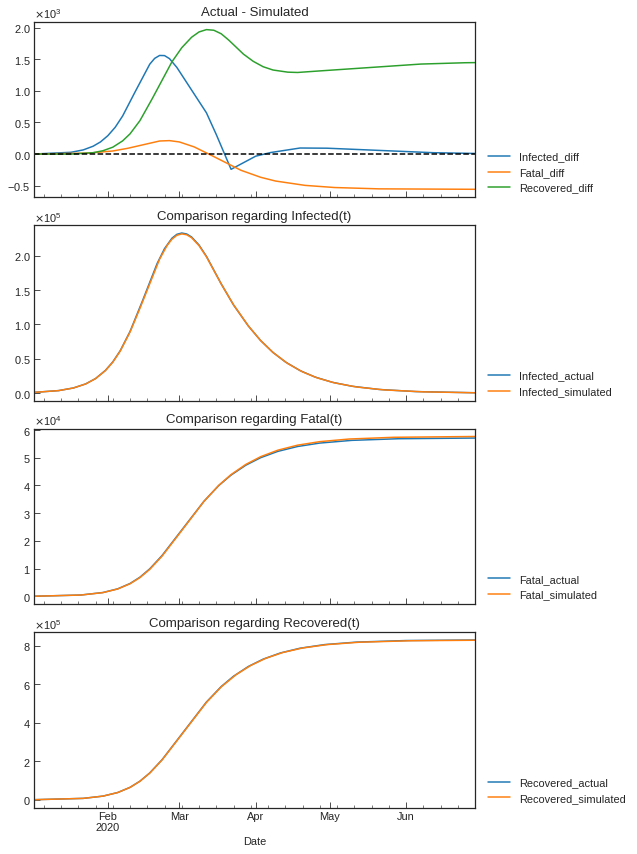

In [142]:
sirf_snl.estimate_accuracy("0th")

In [143]:
latent_period = 6 * 24 * 60
waiting_time = 7 * 24 * 60
latent_waiting_day = latent_period + waiting_time

In [144]:
df = cs.SIRF.EXAMPLE["param_dict"]
tau = 1440
eg_rho2, eg_rho3 = tau / latent_period, tau / waiting_time
(eg_rho2, eg_rho3)

(0.16666666666666666, 0.14285714285714285)

In [145]:
param_dict = cs.SEWIRF.EXAMPLE["param_dict"]
param_dict.update({"rho2":eg_rho2, "eho3": eg_rho3})
pprint(param_dict, compact=True)

{'eho3': 0.14285714285714285,
 'kappa': 0.005,
 'rho1': 0.2,
 'rho2': 0.16666666666666666,
 'rho3': 0.167,
 'sigma': 0.075,
 'theta': 0.002}


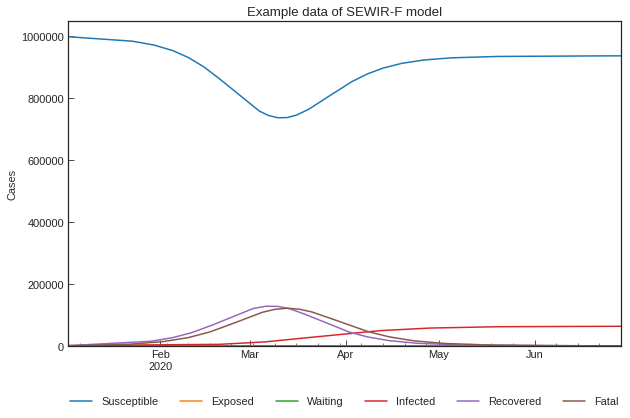

In [146]:
model = cs.SEWIRF
area = {"country": "Full", "province": model.NAME}
# Add records with SIR model
example_data.add(model, param_dict=param_dict, **area)
# Records with model variables
df = example_data.specialized(model, **area)
cs.line_plot(
    df.set_index("Date"),
    title=f"Example data of {model.NAME} model",
    y_integer=True
)

#Factors of model parameters

Pour déterminer ce qu'il faut faire pour minimiser les dommages, nous allons effectuer une analyse de scénario dans la partie suivante. Dans cette partie, nous définirons les facteurs de contrôle des paramètres du SIR-F. Nous utiliserons ici les scénarios suivants. Pour explication, τ=1440 , la date de début est le 01Jan2020, la population est de 1 000 000 et le nom du pays est "Théorique". Ceci n'est pas basé sur des données réelles.

Commentaire :
Pour une prédiction précise de SEWIR-F, nous devons calculer ρ1 et ρ2 avec la linelist (rapports de cas) de chaque pays. Cependant, il est difficile d'obtenir suffisamment de données pour tous les pays et nous utiliserons le modèle SIR-F comme modèle principal dans la partie analyse de scénario.

In [147]:
# Preset of SIR-F parameters
preset_dict = cs.SIRF.EXAMPLE["param_dict"]
preset_dict

{'kappa': 0.005, 'rho': 0.2, 'sigma': 0.075, 'theta': 0.002}

In [148]:
area = {"country": "Theoretical"}
# Create dataset from 01Jan2020 to 31Jan2020
example_data.add(cs.SIRF, step_n=30, **area)

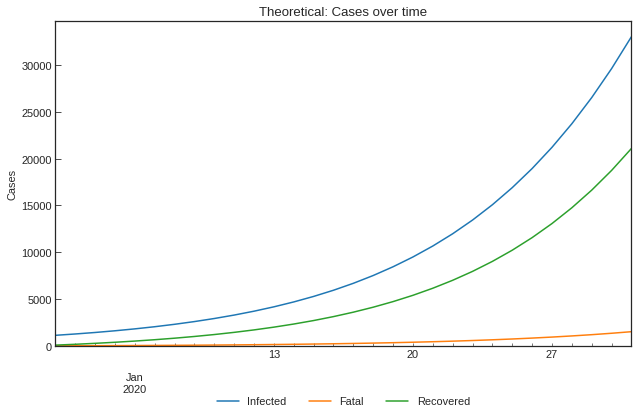

,Date,Infected,Fatal,Recovered
0,2020-01-02,1127,6,80
1,2020-01-03,1270,12,169
2,2020-01-04,1430,19,271
3,2020-01-05,1612,28,385
4,2020-01-06,1816,37,513


,Date,Infected,Fatal,Recovered
25,2020-01-27,21210,940,13068
26,2020-01-28,23730,1061,14753
27,2020-01-29,26524,1196,16637
28,2020-01-30,29616,1347,18741
29,2020-01-31,33030,1515,21088


In [149]:
# Show records with Scenario class
snl = cs.Scenario(example_data, tau=1440, **area)
record_df = snl.records()
display(record_df.head())
display(record_df.tail())

Facteurs de contrôle du taux de contact effectif β

In [150]:
# Value of beta before actions are taken
rho_before = cs.SIRF.EXAMPLE["param_dict"]["rho"]
rho_before

0.2

In [151]:
eg_out_df = go_out("Italy")
eg_out_df

,Age_first,Age_last,Period_of_life,School,Office,Others,Age,Population,Portion
0,0,2,nursery,3,0,0,2,1373871,0.025722
1,3,5,nursery school,4,0,1,5,1441955,0.026997
2,6,10,elementary school,5,0,1,10,2667055,0.049933
3,11,13,middle school,5,0,1,13,1688673,0.031616
4,14,18,high school,6,0,1,18,2829215,0.052969
5,19,25,university/work,3,3,1,25,4087599,0.076529
6,26,35,work,0,6,1,35,6521421,0.122096
7,36,45,work,0,5,1,45,7940871,0.148671
8,46,55,work,0,5,1,55,9560703,0.178998
9,56,65,work,0,5,1,65,8261046,0.154666


In [152]:
gs_before = (eg_out_df[["School", "Office", "Others"]].sum(axis=1) * eg_out_df["Portion"]).sum()
gs_before

5.794427227320437

In [153]:
df = eg_out_df.copy()
df.loc[df["School"] + df["Office"] > 0, "Others"] += 1
df["School"] = 0
df["Office"] *= 0.5
eg_out_df_after = df.copy()
eg_out_df_after

,Age_first,Age_last,Period_of_life,School,Office,Others,Age,Population,Portion
0,0,2,nursery,0,0.0,1,2,1373871,0.025722
1,3,5,nursery school,0,0.0,2,5,1441955,0.026997
2,6,10,elementary school,0,0.0,2,10,2667055,0.049933
3,11,13,middle school,0,0.0,2,13,1688673,0.031616
4,14,18,high school,0,0.0,2,18,2829215,0.052969
5,19,25,university/work,0,1.5,2,25,4087599,0.076529
6,26,35,work,0,3.0,2,35,6521421,0.122096
7,36,45,work,0,2.5,2,45,7940871,0.148671
8,46,55,work,0,2.5,2,55,9560703,0.178998
9,56,65,work,0,2.5,2,65,8261046,0.154666


In [154]:
df = eg_out_df_after.copy()
gs_after = (df[["School", "Office", "Others"]].sum(axis=1) * df["Portion"]).sum()
gs_after

3.8354021528726467

In [155]:
rho_after = rho_before * (gs_after / gs_before)
rho_after / rho_before

0.6619122136505426


Prévision du nombre de cas : avec l'effet des actions à partir du 32ème jour.

Il y a un délai entre le moment du début des actions et celui de l'apparition de l'effet. Comme I est la variable principale, la durée du délai peut être estimée comme la somme de la période de latence et du temps d'attente de la confirmation. Cette valeur [jour] a été calculée dans la section "SIR-F avec les cas exposés/en attente".

In [157]:
# Set 0th phase from 02Jan2020 to 31Jan2020 with preset parameter values
snl.clear(include_past=True)
snl.add(end_date="31Jan2020", model=cs.SIRF, **preset_dict)
snl.summary()
# Add main scenario: the same parameter to 31Dec2020
snl.add(end_date="31Dec2020", name="Main")
# Add lockdown scenario
snl.clear(include_past=False, name="Lockdown")
snl.add(end_date="31Dec2020", name="Lockdown", rho=rho_after).summary()

Type      Start        End  Population    ODE    Rt  theta  \
Scenario Phase                                                                 
Main     0th      Past  02Jan2020  31Jan2020     1000000  SIR-F  2.50  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-F  2.50  0.002   
Lockdown 0th      Past  02Jan2020  31Jan2020     1000000  SIR-F  2.50  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-F  1.65  0.002   

                kappa       rho  sigma   tau  alpha1 [-]  1/alpha2 [day]  \
Scenario Phase                                                             
Main     0th    0.005  0.200000  0.075  1440       0.002           200.0   
         1st    0.005  0.200000  0.075  1440       0.002           200.0   
Lockdown 0th    0.005  0.200000  0.075  1440       0.002           200.0   
         1st    0.005  0.132382  0.075  1440       0.002           200.0   

                1/beta [day]  1/gamma [day]  
Scenario Phase                               
Main     0th             5.0           13.0  
         1st             5.0           13.0  
Lockdown 0th             5.0           13.0  
         1st             7.0           13.0

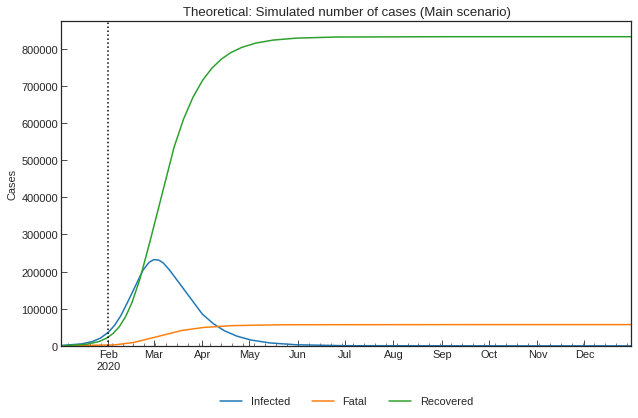

In [158]:
_ = snl.simulate(name="Main")

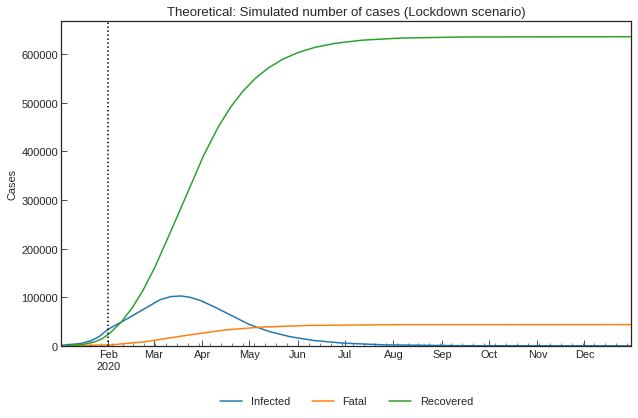

In [159]:
_ = snl.simulate(name="Lockdown")

In [160]:
snl.describe()

,max(Infected),argmax(Infected),Confirmed on 31Dec2020,Infected on 31Dec2020,Fatal on 31Dec2020,1st_Rt
Main,232800,02Mar2020,890043,0,57295,2.50
Lockdown,102662,17Mar2020,679116,6,43716,1.65


Les actions entraînent :

une réduction de la valeur maximale d'Infectés,
un retard du point culminant (argmax) de l'Infecté, et
une prolongation de la période avec COVID-19.

In [161]:
sigma_before = preset_dict["sigma"]
kappa_before = preset_dict["kappa"]
(sigma_before, kappa_before)

(0.075, 0.005)

In [162]:
h_bar_before, s_bar_before = 0.5, 0.5

In [163]:
h_bar_after = h_bar_before * 0.1
s_bar_after = s_bar_before
(h_bar_after, s_bar_after)

(0.05, 0.5)

Impact sur γ et α2 
Actions à entreprendre :
Un nouveau médicament inhibiteur de protéines a été introduit.

In [164]:
sigma_after = sigma_before * (1 - h_bar_after * s_bar_after) / (1 - h_bar_before * s_bar_before)
sigma_after

0.09749999999999999

In [165]:
kappa_after = kappa_before * (h_bar_after * s_bar_after) / (h_bar_before * s_bar_before)
kappa_after

0.0005

Prévoir le nombre de cas : avec l'effet des nouveaux médicaments à partir du 32ème jour.

In [166]:
# Add medicine scenario
snl.clear(name="Medicine")
snl.add(end_date="31Dec2020", name="Medicine", kappa=kappa_after, sigma=sigma_after)
snl.summary()

Type      Start        End  Population    ODE    Rt  theta  \
Scenario Phase                                                                 
Main     0th      Past  02Jan2020  31Jan2020     1000000  SIR-F  2.50  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-F  2.50  0.002   
Lockdown 0th      Past  02Jan2020  31Jan2020     1000000  SIR-F  2.50  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-F  1.65  0.002   
Medicine 0th      Past  02Jan2020  31Jan2020     1000000  SIR-F  2.50  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-F  2.04  0.002   

                 kappa       rho   sigma   tau  alpha1 [-]  1/alpha2 [day]  \
Scenario Phase                                                               
Main     0th    0.0050  0.200000  0.0750  1440       0.002           200.0   
         1st    0.0050  0.200000  0.0750  1440       0.002           200.0   
Lockdown 0th    0.0050  0.200000  0.0750  1440       0.002           200.0   
         1st    0.0050  0.132382  0.0750  1440       0.002           200.0   
Medicine 0th    0.0050  0.200000  0.0750  1440       0.002           200.0   
         1st    0.0005  0.200000  0.0975  1440       0.002          2000.0   

                1/beta [day]  1/gamma [day]  
Scenario Phase                               
Main     0th             5.0           13.0  
         1st             5.0           13.0  
Lockdown 0th             5.0           13.0  
         1st             7.0           13.0  
Medicine 0th             5.0           13.0  
         1st             5.0           10.0

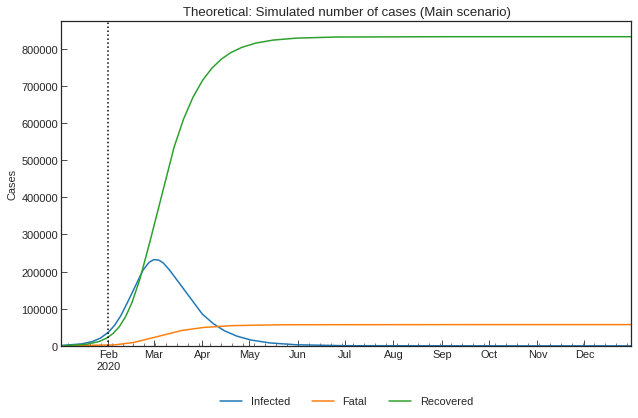

In [167]:
_ = snl.simulate(name="Main")

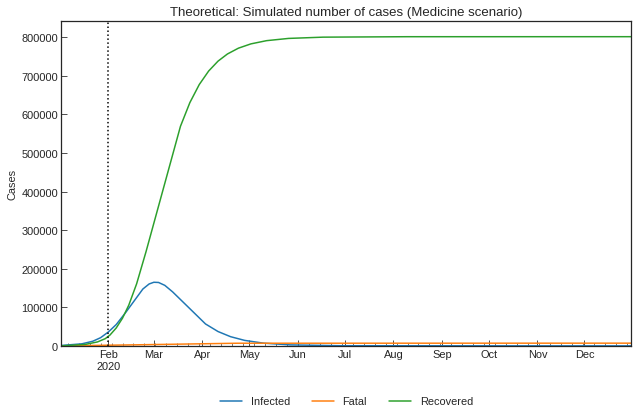

In [168]:
_ = snl.simulate(name="Medicine")

In [169]:
snl.describe()

,max(Infected),argmax(Infected),Confirmed on 31Dec2020,Infected on 31Dec2020,Fatal on 31Dec2020,1st_Rt
Main,232800,02Mar2020,890043,0,57295,2.50
Lockdown,102662,17Mar2020,679116,6,43716,1.65
Medicine,165235,02Mar2020,808440,0,7023,2.04


Les nouveaux médicaments entraînent :

une réduction de la valeur maximale d'Infection,

une réduction des cas mortels, et

une réduction de la période avec COVID-19.

#SIR-F model with vaccination

In [170]:
# Add vaccine scenario
snl.clear("Vaccine")
rho_vac = snl.get("rho", phase="0th") * 0.8
sigma_vac = snl.get("sigma", phase="0th") * 1.2
kappa_vac = snl.get("kappa", phase="0th") * 0.6
snl.add(end_date="31Dec2020", name="Vaccine",  rho=rho_vac, kappa=kappa_vac, sigma=sigma_vac)
snl.summary()

Type      Start        End  Population    ODE    Rt  theta  \
Scenario Phase                                                                 
Main     0th      Past  02Jan2020  31Jan2020     1000000  SIR-F  2.50  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-F  2.50  0.002   
Lockdown 0th      Past  02Jan2020  31Jan2020     1000000  SIR-F  2.50  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-F  1.65  0.002   
Medicine 0th      Past  02Jan2020  31Jan2020     1000000  SIR-F  2.50  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-F  2.04  0.002   
Vaccine  0th      Past  02Jan2020  31Jan2020     1000000  SIR-F  2.50  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-F  1.72  0.002   

                 kappa       rho   sigma   tau  alpha1 [-]  1/alpha2 [day]  \
Scenario Phase                                                               
Main     0th    0.0050  0.200000  0.0750  1440       0.002           200.0   
         1st    0.0050  0.200000  0.0750  1440       0.002           200.0   
Lockdown 0th    0.0050  0.200000  0.0750  1440       0.002           200.0   
         1st    0.0050  0.132382  0.0750  1440       0.002           200.0   
Medicine 0th    0.0050  0.200000  0.0750  1440       0.002           200.0   
         1st    0.0005  0.200000  0.0975  1440       0.002          2000.0   
Vaccine  0th    0.0050  0.200000  0.0750  1440       0.002           200.0   
         1st    0.0030  0.160000  0.0900  1440       0.002           333.0   

                1/beta [day]  1/gamma [day]  
Scenario Phase                               
Main     0th             5.0           13.0  
         1st             5.0           13.0  
Lockdown 0th             5.0           13.0  
         1st             7.0           13.0  
Medicine 0th             5.0           13.0  
         1st             5.0           10.0  
Vaccine  0th             5.0           13.0  
         1st             6.0           11.0

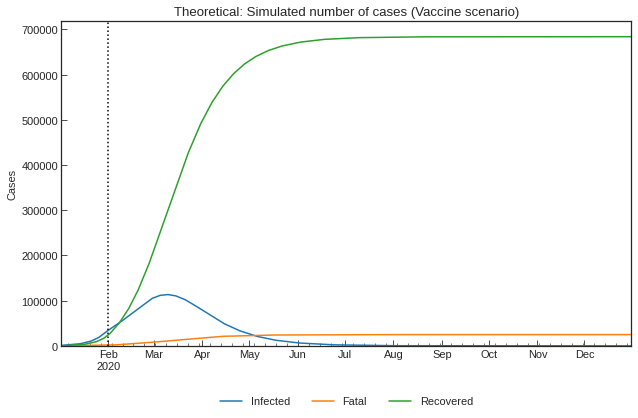

In [171]:
_ = snl.simulate(name="Vaccine")

In [172]:
snl.describe()

,max(Infected),argmax(Infected),Confirmed on 31Dec2020,Infected on 31Dec2020,Fatal on 31Dec2020,1st_Rt
Main,232800,02Mar2020,890043,0,57295,2.50
Lockdown,102662,17Mar2020,679116,6,43716,1.65
Medicine,165235,02Mar2020,808440,0,7023,2.04
Vaccine,113534,09Mar2020,708848,0,24917,1.72


Les vaccins entraînent :

une réduction de la valeur maximale d'infection,

une réduction du nombre de décès, et

une réduction de la période d'utilisation de COVID-19.

Comparison of scenarios for each variables

We can compare the number of cases in the scenarios, specifying variables as follows.

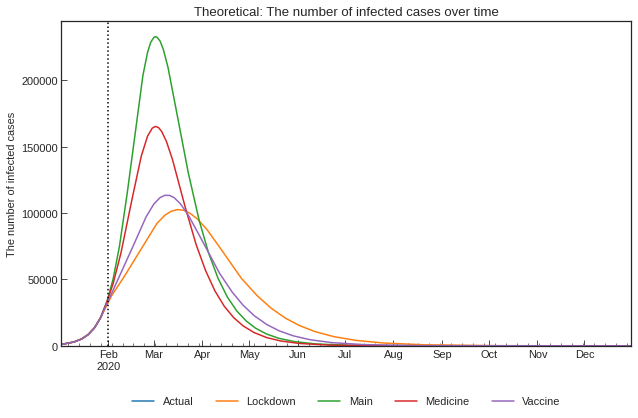

In [173]:
_ = snl.history(target="Infected")

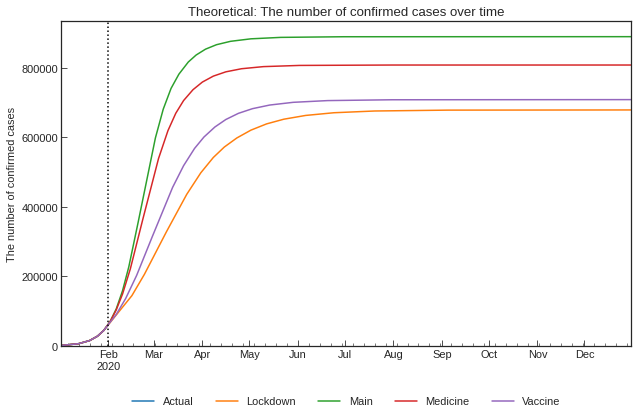

In [174]:
_ = snl.history(target="Confirmed")

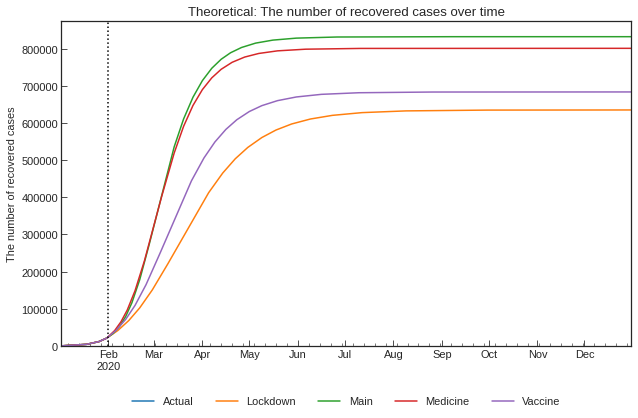

In [175]:
_ = snl.history(target="Recovered")

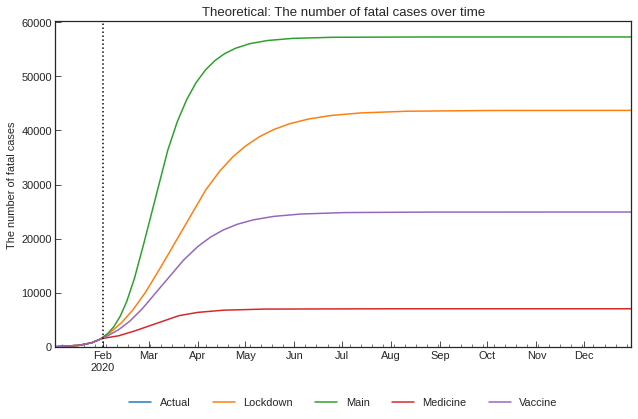

In [176]:
_ = snl.history(target="Fatal")

Analyse des tendances S-R

Dans la section précédente, nous avons constaté que les valeurs des paramètres peuvent être modifiées par des actions. Pour prédire l'avenir, nous devons reconnaître le changement de paramètre à partir des enregistrements réels. La méthode d'analyse des tendances est présentée ici.

In [177]:
import warnings
warnings.simplefilter("ignore")
df = pd.DataFrame()
eg_step_n = 200
eg_tau= 1440
eg_population = cs.SIR.EXAMPLE["population"]
eg_param_dict = {
    "1": {"theta": 0.0002, "kappa": 0.005, "rho": 0.20, "sigma": 0.075},
    "2": {"theta": 0.0002, "kappa": 0.005, "rho": 0.40, "sigma": 0.075},
    "3": {"theta": 0.0002, "kappa": 0.005, "rho": 0.15, "sigma": 0.075},
    "4": {"theta": 0.0002, "kappa": 0.003, "rho": 0.20, "sigma": 0.150},
    "5": {"theta": 0.0000, "kappa": 0.005, "rho": 0.20, "sigma": 0.075},
}

for (num, _dict) in eg_param_dict.items():
    simulator = cs.ODESimulator(country=f"Example {num}")
    simulator.add(
        model=cs.SIRF,
        step_n=eg_step_n,
        population=eg_population,
        param_dict=_dict,
        y0_dict={"Susceptible": 999_000, "Infected": 1000, "Recovered": 0, "Fatal": 0}
    )
    simulator.run()
    _df = simulator.dim(tau=eg_tau, start_date="22Jan2020")
    df = pd.concat([df, _df], axis=0, ignore_index=True)

df["Confirmed"] = df[["Infected", "Recovered", "Fatal"]].sum(axis=1)
eg_ncov_df = df.copy()
eg_ncov_df.tail()

,Date,Country,Province,Susceptible,Infected,Recovered,Fatal,Confirmed
1000,2020-08-05,Example 5,-,111067,224,833165,55544,888933
1001,2020-08-06,Example 5,-,111062,211,833181,55545,888937
1002,2020-08-07,Example 5,-,111057,199,833197,55546,888942
1003,2020-08-08,Example 5,-,111053,188,833211,55547,888946
1004,2020-08-09,Example 5,-,111049,178,833225,55548,888951


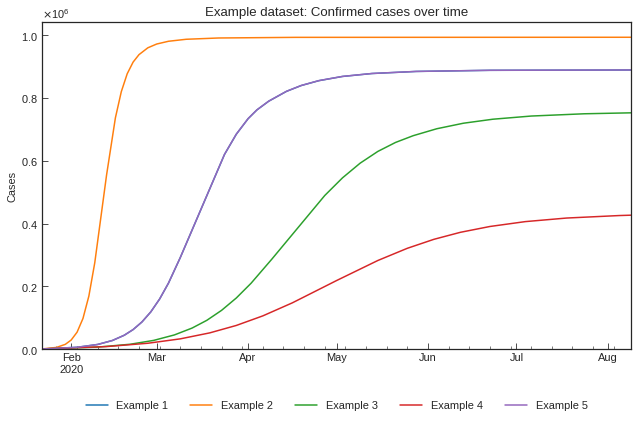

In [178]:
cs.line_plot(
    eg_ncov_df.pivot_table(index="Date", columns="Country", values="Confirmed"),
    "Example dataset: Confirmed cases over time"
)

Les valeurs de l'exemple 1 (κ=0.002) sont pratiquement égales à celles de l'exemple 5 (κ=0.000) comme le montre la figure suivante.

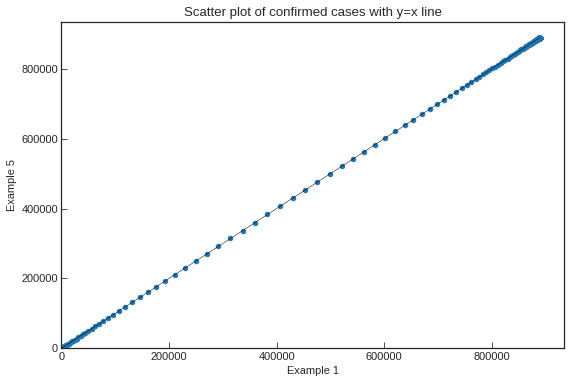

In [179]:
df = eg_ncov_df.pivot_table(index="Date", columns="Country", values="Confirmed")
df.plot.scatter(x="Example 1", y="Example 5")
plt.plot(df["Example 1"], df["Example 1"], color="black", linewidth=0.5)
plt.xlim(0, None)
plt.ylim(0, None)
plt.title("Scatter plot of confirmed cases with y=x line")
plt.show()

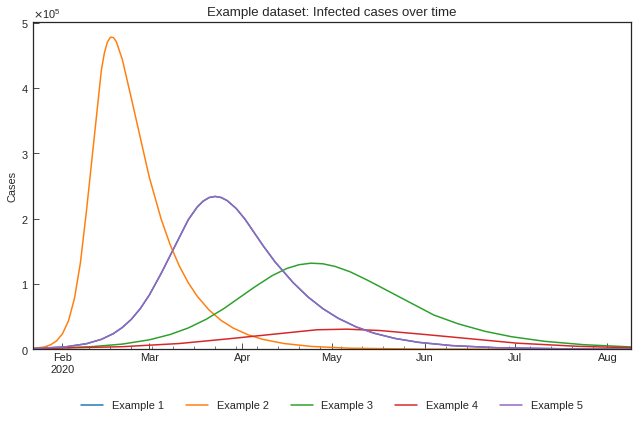

In [180]:
cs.line_plot(
    eg_ncov_df.pivot_table(index="Date", columns="Country", values="Infected"),
    "Example dataset: Infected cases over time"
)

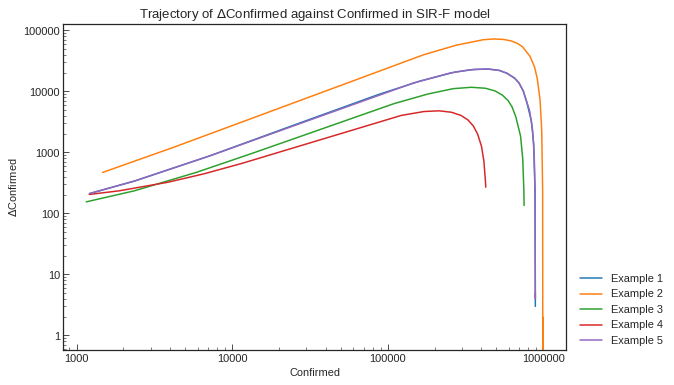

In [181]:
for country in eg_ncov_df["Country"].unique():
    df = eg_ncov_df.copy()
    df = df.loc[df["Country"] == country, :]
    df = df.groupby("Date").last()
    plt.plot(df["Confirmed"], df["Confirmed"].diff(), label=country)

plt.title(r"Trajectory of $\Delta$Confirmed against Confirmed in SIR-F model")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Confirmed")
plt.ylabel(r"$\Delta$Confirmed")
fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
fmt.set_scientific(False)
plt.gca().xaxis.set_major_formatter(fmt)
plt.gca().yaxis.set_major_formatter(fmt)
plt.legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
plt.show()

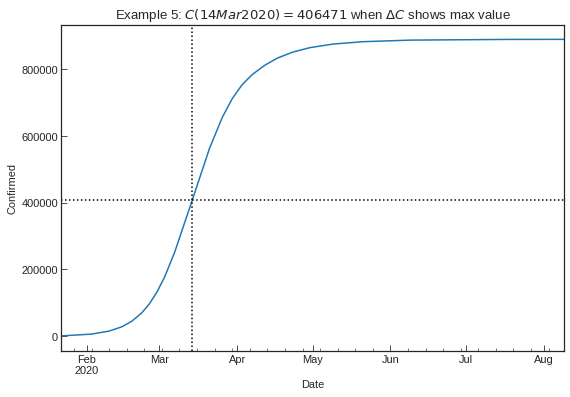

In [182]:
country = "Example 5"
df = eg_ncov_df.copy()
df = df.loc[df["Country"] == country, :].groupby("Date").last()
arg_tt = df["Confirmed"].diff().idxmax()
arg_cc = df.loc[arg_tt, "Confirmed"]
# Plot
df["Confirmed"].plot()
plt.axhline(y=arg_cc, color="black", linestyle=":")
plt.axvline(x=arg_tt, color="black", linestyle=":")
plt.ylabel("Confirmed")
plt.title(
    r'{0}: $C({1})={2}$ when $\Delta C$ shows max value'.format(
        country, arg_tt.strftime("%d%b%Y"), arg_cc)
)
fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
fmt.set_scientific(False)
plt.gca().yaxis.set_major_formatter(fmt)
plt.show()

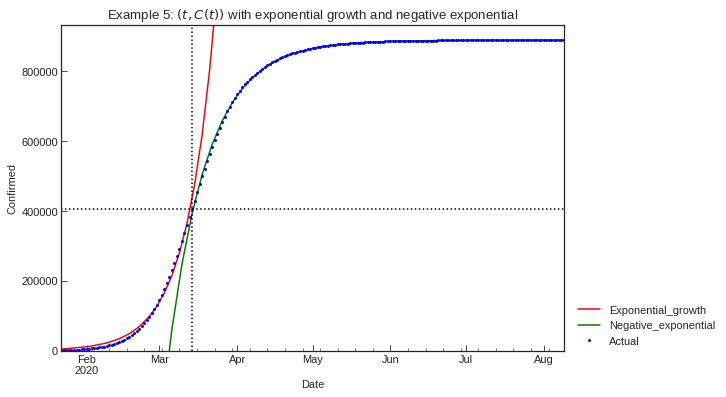

In [183]:
country = "Example 5"
df = eg_ncov_df.copy()
df = df.loc[df["Country"] == country, :].groupby("Date").last()
start_date = df.index.min()
arg_tt = df["Confirmed"].diff().idxmax()
arg_dd = int((arg_tt - start_date).total_seconds() / 60 / 60 / 24)
arg_cc = df.loc[arg_tt, "Confirmed"]
# Convert date to elapsed time (day)
df.index = ((df.index - start_date).total_seconds() / 60 / 60 / 24).astype(np.int64)
# Curve fitting with exponential growth function
f = lambda x, a, b: a * np.exp(b * x)
series = df.loc[df.index <= arg_dd, "Confirmed"]
a_ini = series[0]
b_ini = np.log(arg_cc / a_ini) / arg_dd
param, _ = sci.optimize.curve_fit(f, series.index, series, p0=[a_ini, b_ini])
f_partial = functools.partial(f, a=param[0], b=param[1])
df["Exponential_growth"] = pd.Series(df.index).apply(lambda x: f_partial(x))
# Curve fitting with negative exponential function
f = lambda x, a, b, c: c - a * np.exp(- b * (x - arg_dd))
series = df.loc[df.index >= arg_dd, "Confirmed"]
c_ini = series.max()
a_ini = c_ini - arg_cc
b_ini = series.diff()[arg_dd + 1] / a_ini
param, _ = sci.optimize.curve_fit(f, series.index, series, p0=[a_ini, b_ini, c_ini])
f_partial = functools.partial(f, a=param[0], b=param[1], c=param[2])
df["Negative_exponential"] = pd.Series(df.index).apply(lambda x: f_partial(x))
# Convert elapsed time (day) to date
df.index = start_date + pd.Series(df.index).apply(lambda x: timedelta(days=x))
# Plot
df[["Exponential_growth", "Negative_exponential"]].plot(color=["red", "green"])
df["Actual"] = df["Confirmed"]
df["Actual"].plot(color="blue", marker=".", markeredgewidth=0, linewidth=0)
plt.axhline(y=arg_cc, color="black", linestyle=":")
plt.axvline(x=arg_tt, color="black", linestyle=":")
plt.ylabel("Confirmed")
plt.ylim(0, max(df["Confirmed"]) * 1.05)
plt.title(r"{0}: $(t, C(t))$ with exponential growth and negative exponential".format(country))
fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
fmt.set_scientific(False)
plt.gca().yaxis.set_major_formatter(fmt)
plt.legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
plt.show()

In [184]:
S = sym.symbols("S", cls=sym.Function)
N, R = sym.symbols("N R", positive=True)
beta, gamma = sym.symbols(r"\beta \gamma", positive=True)
dSdR = - beta / (N * gamma) * S(R)
sr = sym.dsolve(S(R).diff(R) - dSdR, hint="separable", ics={S(0): N})
sr

Eq(S(R), N*exp(-R*\beta/(N*\gamma)))

In [185]:
sym.Eq(sym.simplify(sym.log(sr.lhs)), sym.simplify(sym.log(sr.rhs)))

Eq(log(S(R)), log(N) - R*\beta/(N*\gamma))

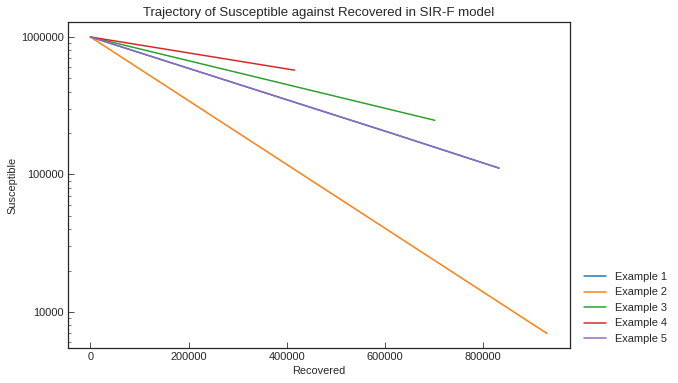

In [186]:
for country in eg_ncov_df["Country"].unique():
    df = eg_ncov_df.copy()
    df = df.loc[df["Country"] == country, :]
    df = df.groupby("Date").last()
    plt.plot(df["Recovered"], eg_population - df["Confirmed"], label=country)

plt.title(r"Trajectory of Susceptible against Recovered in SIR-F model")
plt.yscale("log")
plt.xlabel("Recovered")
plt.ylabel("Susceptible")
fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
fmt.set_scientific(False)
plt.gca().xaxis.set_major_formatter(fmt)
plt.gca().yaxis.set_major_formatter(fmt)
plt.legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
plt.show()

Tendance S-R des données réelles dans un pays
Nous allons effectuer une analyse de tendance S-R pour des données réelles en Italie à titre d'exemple.

Voyons le graphique de la tendance S-R.

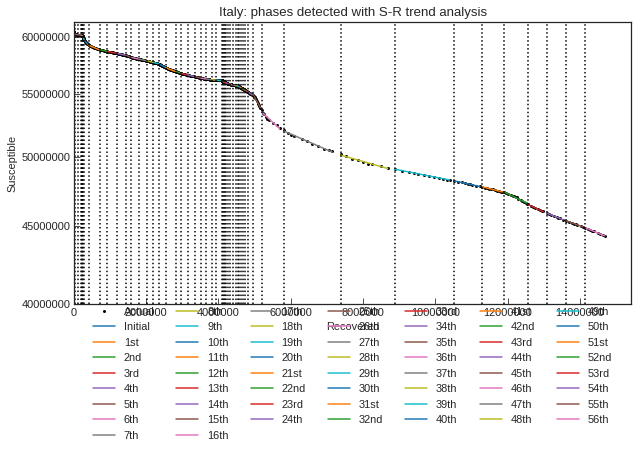

In [187]:
ita_scenario = cs.Scenario(country="Italy")
ita_scenario.register(jhu_data)
_ = ita_scenario.trend()

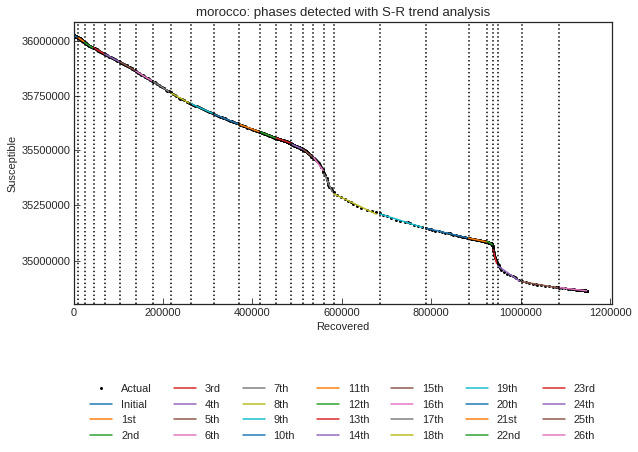

In [188]:
ita_scenario2 = cs.Scenario(country="morocco")
ita_scenario2.register(jhu_data)
_ = ita_scenario2.trend()

Les tracés des données réelles ne montrent pas de ligne. Cela signifie que les paramètres SIR-F ont été modifiés à certains moments. Dans la section suivante, nous trouverons les points de temps, en supposant qu'il y a quatre points de changement dans l'ensemble de données de l'Italie.

#Scénario en Italie

Dans cette section, nous allons effectuer une analyse de scénario en utilisant les dossiers de l'Italie.

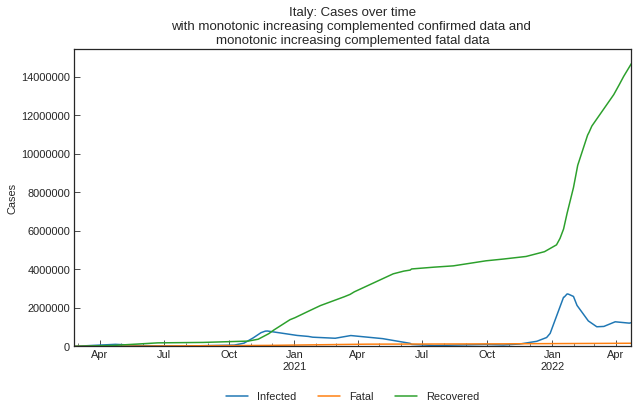

,Date,Infected,Fatal,Recovered
785,2022-04-19,1208279,161893,14387830
786,2022-04-20,1206900,162098,14489444
787,2022-04-21,1222813,162264,14549360
788,2022-04-22,1223122,162466,14622593
789,2022-04-23,1232229,162609,14684371


In [189]:
# ita_scenario = cs.Scenario(country="Italy")
# ita_scenario.register(jhu_data, population_data)
ita_scenario.records().tail()

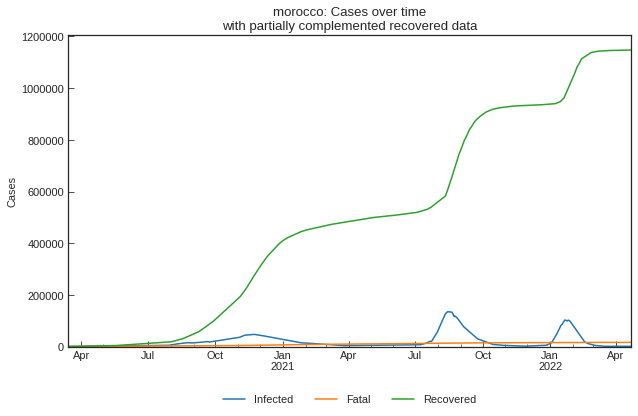

,Date,Infected,Fatal,Recovered
766,2022-04-18,881,16064,1147466
767,2022-04-19,902,16064,1147501
768,2022-04-20,848,16064,1147595
769,2022-04-21,838,16064,1147665
770,2022-04-22,805,16064,1147745


In [190]:
#ita_scenario = cs.Scenario(country="morocco")
#ita_scenario.register(jhu_data, population_data)
ita_scenario2.records().tail()

#S-R Trend analysis

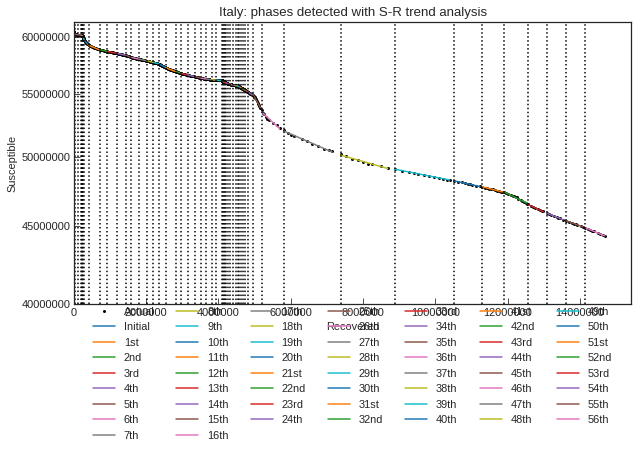

In [191]:
_ = ita_scenario.trend()

#Phases en Italie
Nous utiliserons les points de changement comme date de début des phases. Pour chaque phase, nous appliquerons le modèle SIR-F. Les valeurs τ seront les mêmes.

In [196]:
ita_scenario.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day],RMSLE,Trials,Runtime
0th,Past,24Feb2020,15Mar2020,60421760,SIR-F,7.43,0.000353,0.013300,0.285111,0.025044,1440,0.000,75,3,39,0.344185,368,0 min 12 sec
1st,Past,16Mar2020,23Mar2020,60421760,SIR-F,4.58,0.020248,0.012907,0.154184,0.020088,1440,0.020,77,6,49,0.031056,278,0 min 8 sec
2nd,Past,24Mar2020,02Apr2020,60421760,SIR-F,3.02,0.028693,0.009883,0.080857,0.016112,1440,0.029,101,12,62,0.023146,310,0 min 9 sec
3rd,Past,03Apr2020,14Apr2020,60421760,SIR-F,1.89,0.001613,0.006355,0.042907,0.016304,1440,0.002,157,23,61,0.017634,219,0 min 6 sec
4th,Past,15Apr2020,11May2020,60421760,SIR-F,0.82,0.026882,0.003341,0.023959,0.025042,1440,0.027,299,41,39,0.038822,275,0 min 8 sec
5th,Past,12May2020,30Aug2020,60421760,SIR-F,0.34,0.024738,0.001222,0.011200,0.031247,1440,0.025,818,89,32,0.256134,326,0 min 10 sec
6th,Past,31Aug2020,27Sep2020,60421760,SIR-F,2.63,0.000047,0.000411,0.042494,0.015723,1440,0.000,2435,23,63,0.022479,303,0 min 9 sec
7th,Past,28Sep2020,12Oct2020,60421760,SIR-F,2.48,0.001230,0.000395,0.050692,0.020044,1440,0.001,2533,19,49,0.027170,223,0 min 6 sec
8th,Past,13Oct2020,23Oct2020,60421760,SIR-F,6.27,0.004958,0.000551,0.088306,0.013455,1440,0.005,1814,11,74,0.009691,190,0 min 5 sec
9th,Past,24Oct2020,31Oct2020,60421760,SIR-F,6.43,0.000097,0.000760,0.093204,0.013736,1440,0.000,1316,10,72,0.004407,143,0 min 4 sec


#Estimate SIR-F parameters

In [197]:
ita_scenario.estimate(cs.SIRF, timeout=120)


<SIR-F model: parameter estimation>
Running optimization with 2 CPUs...
	 8th phase (13Oct2020 - 23Oct2020): finished  171 trials in 0 min  5 sec
	 9th phase (24Oct2020 - 31Oct2020): finished  150 trials in 0 min  4 sec
	 0th phase (24Feb2020 - 15Mar2020): finished  372 trials in 0 min 13 sec
	10th phase (01Nov2020 - 13Nov2020): finished  217 trials in 0 min  6 sec
	 1st phase (16Mar2020 - 23Mar2020): finished  279 trials in 0 min  8 sec
	11th phase (14Nov2020 - 27Nov2020): finished  356 trials in 0 min 11 sec
	 2nd phase (24Mar2020 - 02Apr2020): finished  303 trials in 0 min  9 sec
	12th phase (28Nov2020 - 06Dec2020): finished  157 trials in 0 min  4 sec
	13th phase (07Dec2020 - 16Dec2020): finished  123 trials in 0 min  3 sec
	 3rd phase (03Apr2020 - 14Apr2020): finished  223 trials in 0 min  6 sec
	14th phase (17Dec2020 - 29Dec2020): finished  123 trials in 0 min  3 sec
	15th phase (30Dec2020 - 07Jan2021): finished  247 trials in 0 min  7 sec
	 4th phase (15Apr2020 - 11May2020): fi

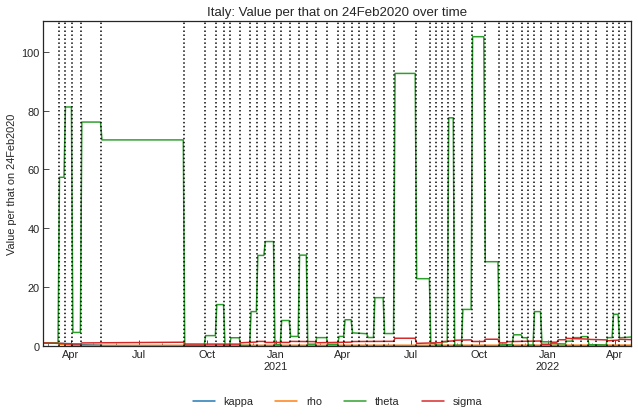

In [198]:
_ = ita_scenario.history_rate()

Le taux de contact effectif non dimensionnel ρ a été réduit dans les phases.

#Pourquoi ρ a-t-il été réduit ?

Les mesures prises en Italie sont présentées ici.

In [199]:
def _color(data_df):
    df = data_df.copy()
    df.loc[:, :] = str()
    df.iloc[[3, 6, 8], :] = "background-color: lightgreen"
    return df

ita_action_df.style.apply(_color, axis=None)

NameError: ignored

#Effet de la fermeture des écoles et du lockdown
Selon le premier rapport du projet de surveillance de la mobilité COVID-19 du 13 mars 2020, le gouvernement italien a décrété un lockdown national le 9 mars 2020 et a demandé à toutes les personnes de rester chez elles. Cette mesure a entraîné une réduction moyenne de 19 % des rencontres potentielles au cours de la troisième semaine (du 7 mars 2020 au 10 mars 2020).


Ici, nous allons prédire l'effet de la fermeture des écoles (commencée avant le 04 mars 2020) et du confinement le 13 mars 2020, en supposant que l'effet se manifestera dès le début de la troisième phase.

In [200]:
ita_scenario.get("Start", name="Main", phase="3rd")

'03Apr2020'

In [201]:
c_before, c_after = 1.0, 0.81

In [202]:
ita_out_df = go_out("Italy")
ita_out_df

,Age_first,Age_last,Period_of_life,School,Office,Others,Age,Population,Portion
0,0,2,nursery,3,0,0,2,1373871,0.025722
1,3,5,nursery school,4,0,1,5,1441955,0.026997
2,6,10,elementary school,5,0,1,10,2667055,0.049933
3,11,13,middle school,5,0,1,13,1688673,0.031616
4,14,18,high school,6,0,1,18,2829215,0.052969
5,19,25,university/work,3,3,1,25,4087599,0.076529
6,26,35,work,0,6,1,35,6521421,0.122096
7,36,45,work,0,5,1,45,7940871,0.148671
8,46,55,work,0,5,1,55,9560703,0.178998
9,56,65,work,0,5,1,65,8261046,0.154666


In [203]:
df = ita_out_df.copy()
gs_before = (df[["School", "Office", "Others"]].sum(axis=1) * df["Portion"]).sum()
print(f"{round(gs_before, 1)} days in a week susceptible people go out.")

5.8 days in a week susceptible people go out.


In [204]:
rho_before = ita_scenario.get("rho", name="Main", phase="1st")
rho_after = ita_scenario.get("rho", name="Main", phase="3rd")
gs_after = rho_after / rho_before / c_after * gs_before * c_before
print(f"{round(gs_after, 1)} days in a week susceptible people go out after lockdown.")

2.0 days in a week susceptible people go out after lockdown.


Appliquons cette valeur à la table go_out !

Nous supposons que les travailleurs se rendent à leur bureau un jour par semaine.

In [205]:
df = ita_out_df.copy()
df["School"] = 0
df.loc[df["Office"] > 0, "Office"] = 1
sum_so = (df[["School", "Office"]].sum(axis=1) * df["Portion"]).sum()
df.loc[df["Others"] > 0, "Others"] = round(gs_after - sum_so, 1)
ita_out_after_df = df.copy()
ita_out_after_df

,Age_first,Age_last,Period_of_life,School,Office,Others,Age,Population,Portion
0,0,2,nursery,0,0,0.0,2,1373871,0.025722
1,3,5,nursery school,0,0,1.3,5,1441955,0.026997
2,6,10,elementary school,0,0,1.3,10,2667055,0.049933
3,11,13,middle school,0,0,1.3,13,1688673,0.031616
4,14,18,high school,0,0,1.3,18,2829215,0.052969
5,19,25,university/work,0,1,1.3,25,4087599,0.076529
6,26,35,work,0,1,1.3,35,6521421,0.122096
7,36,45,work,0,1,1.3,45,7940871,0.148671
8,46,55,work,0,1,1.3,55,9560703,0.178998
9,56,65,work,0,1,1.3,65,8261046,0.154666


In [206]:
df = ita_out_after_df.copy()
gs_after2 = (df[["School", "Office", "Others"]].sum(axis=1) * df["Portion"]).sum()
print(f"{round(gs_after2, 1)} days in a week susceptible people go out after lockdown.")

1.9 days in a week susceptible people go out after lockdown.


#Prédire l'avenir avec les derniers paramètres
Dans une semaine,

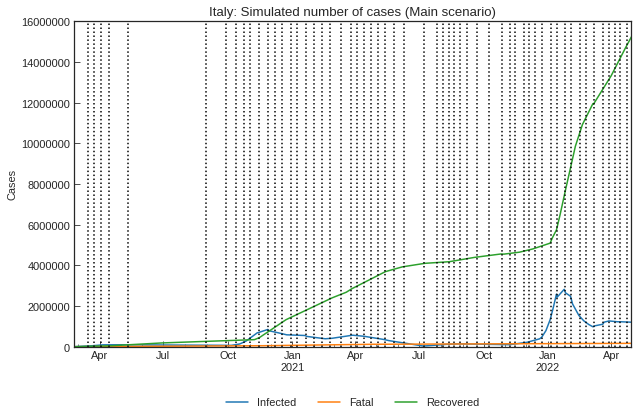

,Date,Infected,Fatal,Recovered
790,2022-04-24 00:00:00,1216105,164216,14855999
791,2022-04-25 00:00:00,1214516,164476,14920329
792,2022-04-26 00:00:00,1212840,164735,14984572
793,2022-04-27 00:00:00,1211076,164994,15048724
794,2022-04-28 00:00:00,1209227,165252,15112781
795,2022-04-29 00:00:00,1207292,165510,15176738
796,2022-04-30 00:00:00,1205273,165767,15240590


In [207]:
ita_scenario.clear()
ita_scenario.add(days=7)
ita_scenario.simulate().tail(7).style.background_gradient(axis=0)

In 30 days,

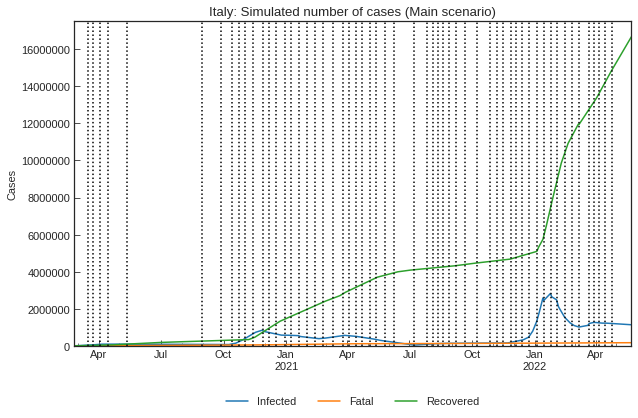

,Date,Infected,Fatal,Recovered
813,2022-05-17 00:00:00,1158724,170044,16305886
814,2022-05-18 00:00:00,1155317,170289,16367131
815,2022-05-19 00:00:00,1151842,170534,16428193
816,2022-05-20 00:00:00,1148299,170777,16489069
817,2022-05-21 00:00:00,1144690,171020,16549757
818,2022-05-22 00:00:00,1141016,171262,16610251
819,2022-05-23 00:00:00,1137278,171503,16670549


In [208]:
ita_scenario.clear()
ita_scenario.add(days=30)
ita_scenario.simulate().tail(7).style.background_gradient(axis=0)

In the long-term,

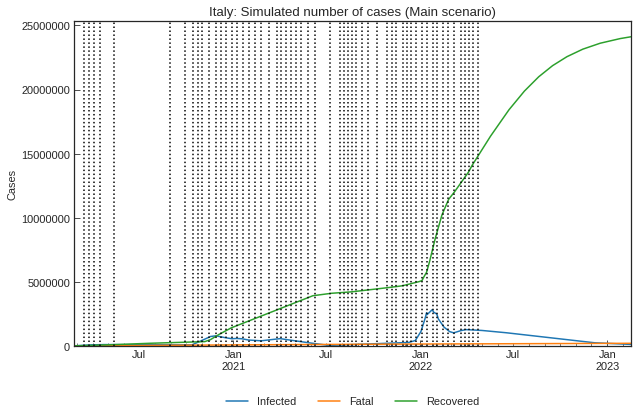

In [209]:
ita_scenario.clear()
ita_scenario.add(days=300)
_ = ita_scenario.simulate()

#Effet des nouveaux médicaments attendus

De nouveaux médicaments sont nécessaires pour que les patients puissent se remettre plus rapidement de la maladie. La stratégie de repositionnement des médicaments (c'est-à-dire la recherche de candidats efficaces à partir de la bibliothèque de médicaments existants pour différentes maladies) est utilisée pour développer les médicaments de COVID-19. Par exemple, le Remdesivir (USAN) et le Favipiravir (AVIGAN) sont des candidats.

In [210]:
sigma_before = ita_scenario.get("sigma", name="Main", phase="3rd")
kappa_before = ita_scenario.get("kappa", name="Main", phase="3rd")
(sigma_before, kappa_before)

(0.016303851647855326, 0.00635470194585825)

In [211]:
# Tentative evaluation with clinical study
sigma_med = ita_scenario.get("tau", name="Main", phase="3rd") * (25 / 53) / ((10 + 18) * 1440)
kappa_med = ita_scenario.get("tau", name="Main", phase="3rd") * (7 / 53) / ((10 + 18) * 1440)
(sigma_med, kappa_med)

(0.016846361185983826, 0.0047169811320754715)

In three 90 days,

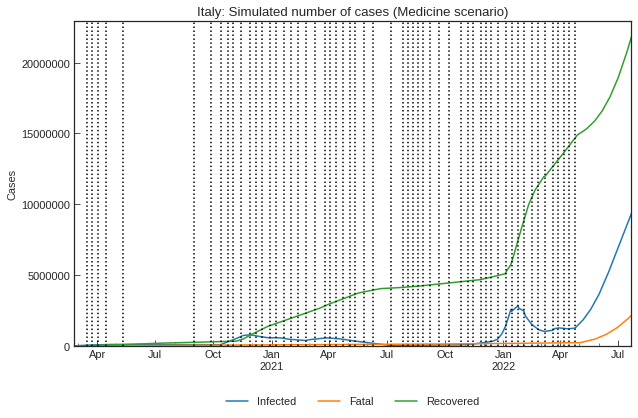

,Date,Infected,Fatal,Recovered
873,2022-07-16 00:00:00,8742364,1896038,20918927
874,2022-07-17 00:00:00,8848921,1937844,21067105
875,2022-07-18 00:00:00,8953668,1980149,21217062
876,2022-07-19 00:00:00,9056505,2022945,21368768
877,2022-07-20 00:00:00,9157332,2066220,21522190
878,2022-07-21 00:00:00,9256047,2109967,21677293
879,2022-07-22 00:00:00,9352553,2154174,21834040


In [212]:
ita_scenario.clear(name="Medicine")
ita_scenario.add(days=90, name="Medicine", kappa=kappa_med, sigma=sigma_med)
ita_scenario.simulate(name="Medicine").tail(7).style.background_gradient(axis=0)

In the long-term,

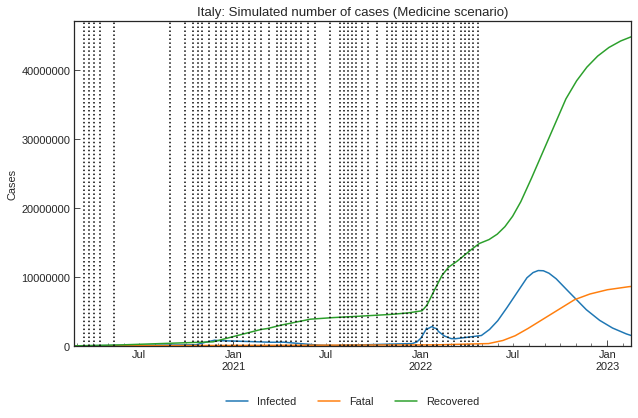

In [213]:
ita_scenario.clear(name="Medicine")
ita_scenario.add(days=300, name="Medicine", kappa=kappa_med, sigma=sigma_med)
_ = ita_scenario.simulate(name="Medicine")

In [ ]:
import covsirphy as cs
# Download and update datasets
loader = cs.DataLoader("input")
data_dict = loader.collect()
# Select country name and register the data
snl = cs.Scenario(country="Japan")
snl.register(**data_dict)
# Check records
snl.records()
# S-R trend analysis
snl.trend().summary()
# Parameter estimation of SIR-F model
snl.estimate(cs.SIRF)
# History of reproduction number
snl.history(target="Rt")
# History of parameters
snl.history_rate()
snl.history(target="rho")
# Baseline
snl.add(days=30)
# Forecasting
snl.predict(days=30)
snl.adjust_end()
snl.rename(old="Multivariate_regression_Likely", new="Likely")
snl.delete_matched(pattern=r"^Multi")
# Compare scenarios
snl.describe()
# Summary
snl.summary()
# Simulation
snl.simulate()

In [ ]:
import covsirphy as cs
loader2 = cs.DataLoader(directory="confirmed", update_interval=24)

In [ ]:
loader.read_csv("corona_morocco.csv")
print(loader.local)